![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.Clinical_Named_Entity_Recognition_Model.ipynb)

# Clinical Named Entity Recognition (NER)

##  1. NER Model Implementation in Spark NLP

  The deep neural network architecture for NER model in
Spark NLP is BiLSTM-CNN-Char framework. a slightly modified version of the architecture proposed by Jason PC Chiu and Eric Nichols ([Named Entity Recognition with Bidirectional LSTM-CNNs
](https://arxiv.org/abs/1511.08308)). It is a neural network architecture that
automatically detects word and character-level features using a
hybrid bidirectional LSTM and CNN architecture, eliminating
the need for most feature engineering steps.

  In the original framework, the CNN extracts a fixed length
feature vector from character-level features. For each word,
these vectors are concatenated and fed to the BLSTM network
and then to the output layers. They employed a stacked
bi-directional recurrent neural network with long short-term
memory units to transform word features into named entity
tag scores. The extracted features of each word are fed into a
forward LSTM network and a backward LSTM network. The
output of each network at each time step is decoded by a linear
layer and a log-softmax layer into log-probabilities for each tag
category. These two vectors are then simply added together to
produce the final output. In the architecture of the proposed framework in the original paper, 50-dimensional pretrained word
embeddings is used for word features, 25-dimension character
embeddings is used for char features, and capitalization features
(allCaps, upperInitial, lowercase, mixedCaps, noinfo) are used
for case features.

## 2. Blogposts and videos:

- [How to Setup Spark NLP for HEALTHCARE on UBUNTU - Video](https://www.youtube.com/watch?v=yKnF-_oz0GE)

- [Named Entity Recognition (NER) with BERT in Spark NLP](https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77)

- [State of the art Clinical Named Entity Recognition in Spark NLP - Youtube](https://www.youtube.com/watch?v=YM-e4eOiQ34)

- [Named Entity Recognition for Healthcare with SparkNLP NerDL and NerCRF](https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571)

- [Named Entity Recognition for Clinical Text](https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180)

## 3. Colab Setup

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

In [2]:
license_keys.keys()

dict_keys(['SPARK_NLP_LICENSE', 'SECRET', 'JSL_VERSION', 'PUBLIC_VERSION', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'SPARK_OCR_LICENSE', 'SPARK_OCR_SECRET', 'OCR_VERSION'])

In [3]:
license_keys['JSL_VERSION']

'3.5.0'

In [4]:
license_keys['PUBLIC_VERSION']

'3.4.2'

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [6]:
import json
import os

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 3.4.2
Spark NLP_JSL Version : 3.5.0


In [ ]:
# if you want to start the session with custom params as in start function above
from pyspark.sql import SparkSession

def start(SECRET):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+PUBLIC_VERSION) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+SECRET+"/spark-nlp-jsl-"+JSL_VERSION+".jar")
      
    return builder.getOrCreate()

#spark = start(SECRET)

## 4. Clinical NER Pipeline (with pretrained models)

- **Clinical NER Models**

|   index | model_name                     |   index | model_name                        |   index | model_name                        |   index | model_name                 |
|--------:|:-------------------------------|--------:|:----------------------------------|--------:|:----------------------------------|--------:|:---------------------------|
|       1 | jsl_ner_wip_clinical           |       2 | ner_chexpert                      |       3 | ner_deid_subentity (German)       |       4 | ner_jsl_greedy             |
|       5 | jsl_ner_wip_greedy_clinical    |       6 | ner_clinical                      |       7 | ner_diseases_large                |       8 | ner_jsl_slim               |
|       9 | jsl_ner_wip_modifier_clinical  |      10 | ner_clinical_icdem                |      11 | ner_drugs                         |      12 | ner_measurements_clinical  |
|      13 | jsl_rd_ner_wip_greedy_clinical |      14 | ner_clinical_large                |      15 | ner_drugs_greedy                  |      16 | ner_medmentions_coarse     |
|      17 | ner_ade_clinical               |      18 | ner_clinical_large_en             |      19 | ner_drugs_large                   |      20 | ner_posology               |
|      21 | ner_ade_clinicalbert           |      22 | ner_deid_augmented                |      23 | ner_events_admission_clinical     |      24 | ner_posology_experimental  |
|      25 | ner_ade_healthcare             |      26 | ner_deid_enriched                 |      27 | ner_events_clinical               |      28 | ner_posology_greedy        |
|      29 | ner_anatomy                    |      30 | ner_deid_generic_augmented        |      31 | ner_events_healthcare             |      32 | ner_posology_healthcare    |
|      33 | ner_anatomy_coarse             |      34 | ner_deid_generic (German)         |      35 | ner_genetic_variants              |      36 | ner_posology_large         |
|      37 | ner_bacterial_species          |      38 | ner_deid_large                    |      39 | ner_healthcare                    |      40 | ner_posology_small         |
|      41 | ner_bionlp                     |      42 | ner_deid_sd                       |      43 | ner_human_phenotype_gene_clinical |      44 | ner_profiling_clinical     |
|      45 | ner_cancer_genetics            |      46 | ner_deid_sd_large                 |      47 | ner_human_phenotype_go_clinical   |      48 | ner_radiology              |
|      49 | ner_cellular                   |      50 | ner_deid_subentity_augmented      |      51 | ner_jsl                           |      52 | ner_radiology_wip_clinical |
|      53 | ner_chemicals                  |      54 | ner_deid_synthetic                |      55 | ner_jsl_enriched                  |      56 | ner_risk_factors           |
|      57 | ner_chemprot_clinical          |      58 | ner_deidentify_dl                 |      59 | ner_nihss                         |      60 | ner_biomarker              |
|      61 | ner_abbreviation_clinical      |      62 | ner_deid_subentity_augmented_i2b2 |      63 | ner_diseases                      |      64 | ner_drugprot_clinical      |
|      65 | ner_nature_nero_clinical_en    |      66 | ner_supplement_clinical_en        |         |                                   |         |                            |




- **BioBert NER Models**

|   index | model_name                    |   index | model_name                |   index | model_name                       |   index | model_name                 |
|--------:|:------------------------------|--------:|:--------------------------|--------:|:---------------------------------|--------:|:---------------------------|
|       1 | jsl_ner_wip_greedy_biobert    |       7 | ner_cellular_biobert      |      13 | ner_events_biobert               |      18 | ner_jsl_greedy_biobert     |
|       2 | jsl_rd_ner_wip_greedy_biobert |       8 | ner_chemprot_biobert      |      14 | ner_human_phenotype_gene_biobert |      19 | ner_posology_biobert       |
|       3 | ner_ade_biobert               |       9 | ner_clinical_biobert      |      15 | ner_human_phenotype_go_biobert   |      20 | ner_posology_large_biobert |
|       4 | ner_anatomy_biobert           |      10 | ner_deid_biobert          |      16 | ner_jsl_biobert                  |      21 | ner_profiling_biobert      |
|       5 | ner_anatomy_coarse_biobert    |      11 | ner_deid_enriched_biobert |      17 | ner_jsl_enriched_biobert         |      22 | ner_risk_factors_biobert   |
|       6 | ner_bionlp_biobert            |      12 | ner_diseases_biobert      |         |                                  |         |                            |


- **BertForTokenClassification Clinical NER models**

|    | model_name                         |
|---:|:-----------------------------------|
|  1 | bert_token_classifier_ner_ade      |
|  2 | bert_token_classifier_ner_clinical |
|  3 | bert_token_classifier_ner_deid     |
|  4 | bert_token_classifier_ner_drugs    |
|  5 | bert_token_classifier_ner_jsl      |
|  6 | bert_token_classifier_ner_jsl_slim |
|  7 | bert_token_classifier_ner_bionlp   |
|  8 | bert_token_classifier_ner_bacteria |
|  9 | bert_token_classifier_ner_anatomy  |
| 10 | bert_token_classifier_ner_cellular |
| 11 | bert_token_classifier_ner_chemprot |
| 12 | bert_token_classifier_ner_chemicals|
| 13 | bert_token_classifier_drug_development_trials   |



**You can find all these models and more [NLP Models Hub](https://nlp.johnsnowlabs.com/models?task=Named+Entity+Recognition&edition=Spark+NLP+for+Healthcare)**

In [7]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")
 
# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical","en","clinical/models")\
    .setInputCols(["sentence","token"])\
    .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = MedicalNerModel.pretrained("ner_clinical_large","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("ner")\
    .setLabelCasing("upper") #decide if we want to return the tags in upper or lower case 

ner_converter = NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical_large download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [8]:
model.stages

[DocumentAssembler_f610b229e080,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_9f9b3d3398a1,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_1a8637089929,
 NerConverter_b5faf376a8b0]

In [9]:
clinical_ner.getClasses()

['O',
 'B-TREATMENT',
 'I-TREATMENT',
 'B-PROBLEM',
 'I-PROBLEM',
 'B-TEST',
 'I-TEST']

In [10]:
clinical_ner.extractParamMap()

{Param(parent='MedicalNerModel_1a8637089929', name='batchSize', doc='Size of every batch'): 64,
 Param(parent='MedicalNerModel_1a8637089929', name='classes', doc='get the tags used to trained this MedicalNerModel'): ['O',
  'B-TREATMENT',
  'I-TREATMENT',
  'B-PROBLEM',
  'I-PROBLEM',
  'B-TEST',
  'I-TEST'],
 Param(parent='MedicalNerModel_1a8637089929', name='includeAllConfidenceScores', doc='whether to include all confidence scores in annotation metadata or just the score of the predicted tag'): False,
 Param(parent='MedicalNerModel_1a8637089929', name='includeConfidence', doc='whether to include confidence scores in annotation metadata'): True,
 Param(parent='MedicalNerModel_1a8637089929', name='inferenceBatchSize', doc='number of sentences to process in a single batch during inference'): 1,
 Param(parent='MedicalNerModel_1a8637089929', name='inputCols', doc='previous annotations columns, if renamed'): ['sentence',
  'token',
  'embeddings'],
 Param(parent='MedicalNerModel_1a8637089

In [11]:
clinical_ner.getStorageRef()

'clinical'

In [14]:
from sparknlp_jsl.compatibility import Compatibility 
import pandas as pd

compatibility = Compatibility(spark)

models = compatibility.findVersion('ner') 

models_df = pd.DataFrame([dict(x) for x in list(models)])
models_df

,name,sparkVersion,version,language,date,readyToUse
0,nerdl_tumour_demo,2,1.7.3,en,2018-12-19T16:52:37.735,true
1,nercrf_tumour_demo,2,1.7.3,en,2018-12-19T17:23:53.776,true
2,nerdl_tumour_demo,2.4,1.8.0,en,2018-12-22T04:21:25.574,true
3,nercrf_tumour_demo,2.4,1.8.0,en,2018-12-22T04:46:26.992,true
4,nercrf_deid,2.4,1.8.0,en,2018-12-23T00:44:17.698,true
...,...,...,...,...,...,...
453,ner_anatomy_biobert_pipeline,3.0,3.4.1,en,2022-03-21T14:43:26.641,true
454,ner_ade_healthcare_pipeline,3.0,3.4.1,en,2022-03-22T10:16:20.015,true
455,ner_ade_clinical_pipeline,3.0,3.4.1,en,2022-03-21T14:55:30.624,true
456,ner_deid_subentity,3.0,3.4.2,pt,2022-04-13T09:04:03.338,true


In [ ]:
# Downloading sample datasets.
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/mt_samples.csv

In [ ]:
import pandas as pd

# mt_samples_df = spark.read.csv("mt_samples.csv", header=True)

mt_samples_df = spark.createDataFrame(pd.read_csv("mt_samples.csv").reset_index())

In [ ]:
mt_samples_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
mt_samples_df.show()

+-----+--------------------+
|index|                text|
+-----+--------------------+
|    0|Sample Type / Med...|
|    1|Sample Type / Med...|
|    2|Sample Type / Med...|
|    3|Sample Type / Med...|
|    4|Sample Type / Med...|
|    5|Sample Type / Med...|
|    6|Sample Type / Med...|
|    7|Sample Type / Med...|
|    8|Sample Type / Med...|
|    9|Sample Type / Med...|
|   10|Sample Type / Med...|
|   11|Sample Type / Med...|
|   12|Sample Type / Med...|
|   13|Sample Type / Med...|
|   14|Sample Type / Med...|
|   15|Sample Type / Med...|
|   16|Sample Type / Med...|
|   17|Sample Type / Med...|
|   18|Sample Type / Med...|
|   19|Sample Type / Med...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
print(mt_samples_df.limit(1).collect()[0]['text'])

Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Discharge Summary - Mesothelioma - 1
Description:
Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:
Mesothelioma.
SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
PROCEDURES
1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.
2. On August 20, 2007, thoracentesis.
3. On August 31, 2007, Port-A-Cath placement.
HISTORY AND PHYSICAL:
The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care cen

In [ ]:
result = model.transform(mt_samples_df.limit(100)).cache()

In [ ]:
result.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|Sample Type / Med...|[{document, 0, 54...|[{document, 0, 54...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 118, 129...|
|    1|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 54...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 68, 92, ...|
|    2|Sample Type / Med...|[{document, 0, 42...|[{document, 0, 54...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 68, 73, ...|
|    3|Sample Type / Med...|[{document, 0, 20...|[{document, 0, 54...|

In [ ]:
result.select('token.result','ner.result').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, Discharge, Sum...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-PROBLEM, O, B-PROBLEM, I-PROBLEM, ...|
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, BCCa, Excision...|[O, O, O, O, O, O, O, O, O, O, O, O, B-TREATMENT, I-TREATMENT, I-TREATMENT, I-TREA

In [ ]:
result_df = result.select(F.explode(F.arrays_zip("token.result","ner.result")).alias("cols"))\
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"))

result_df.show(50, truncate=100)

+-------------+---------+
|        token|ner_label|
+-------------+---------+
|       Sample|        O|
|         Type|        O|
|            /|        O|
|      Medical|        O|
|    Specialty|        O|
|            :|        O|
|   Hematology|        O|
|            -|        O|
|     Oncology|        O|
|       Sample|        O|
|         Name|        O|
|            :|        O|
|    Discharge|        O|
|      Summary|        O|
|            -|        O|
| Mesothelioma|        O|
|            -|        O|
|            1|        O|
|  Description|        O|
|            :|        O|
| Mesothelioma|B-PROBLEM|
|            ,|        O|
|      pleural|B-PROBLEM|
|     effusion|I-PROBLEM|
|            ,|        O|
|       atrial|B-PROBLEM|
| fibrillation|I-PROBLEM|
|            ,|        O|
|       anemia|B-PROBLEM|
|            ,|        O|
|      ascites|B-PROBLEM|
|            ,|        O|
|   esophageal|B-PROBLEM|
|       reflux|I-PROBLEM|
|            ,|        O|
|          a

In [ ]:
result_df.select("token", "ner_label")\
         .groupBy('ner_label').count()\
         .orderBy('count', ascending=False)\
         .show(truncate=False)

+-----------+-----+
|ner_label  |count|
+-----------+-----+
|O          |25751|
|I-PROBLEM  |3139 |
|B-PROBLEM  |2141 |
|I-TREATMENT|1301 |
|B-TREATMENT|1254 |
|I-TEST     |918  |
|B-TEST     |792  |
+-----------+-----+



In [ ]:
result.select('ner_chunk').take(1)

[Row(ner_chunk=[Row(annotatorType='chunk', begin=118, end=129, result='Mesothelioma', metadata={'sentence': '2', 'chunk': '0', 'entity': 'PROBLEM', 'confidence': '0.9993'}, embeddings=[]), Row(annotatorType='chunk', begin=132, end=147, result='pleural effusion', metadata={'sentence': '2', 'chunk': '1', 'entity': 'PROBLEM', 'confidence': '0.8649'}, embeddings=[]), Row(annotatorType='chunk', begin=150, end=168, result='atrial fibrillation', metadata={'sentence': '2', 'chunk': '2', 'entity': 'PROBLEM', 'confidence': '0.99899995'}, embeddings=[]), Row(annotatorType='chunk', begin=171, end=176, result='anemia', metadata={'sentence': '2', 'chunk': '3', 'entity': 'PROBLEM', 'confidence': '0.9999'}, embeddings=[]), Row(annotatorType='chunk', begin=179, end=185, result='ascites', metadata={'sentence': '2', 'chunk': '4', 'entity': 'PROBLEM', 'confidence': '0.3627'}, embeddings=[]), Row(annotatorType='chunk', begin=188, end=204, result='esophageal reflux', metadata={'sentence': '2', 'chunk': '5',

In [ ]:
result.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata')).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+-------------------------+---------+
|chunk                    |ner_label|
+-------------------------+---------+
|Mesothelioma             |PROBLEM  |
|pleural effusion         |PROBLEM  |
|atrial fibrillation      |PROBLEM  |
|anemia                   |PROBLEM  |
|ascites                  |PROBLEM  |
|esophageal reflux        |PROBLEM  |
|deep venous thrombosis   |PROBLEM  |
|Mesothelioma             |PROBLEM  |
|Pleural effusion         |PROBLEM  |
|atrial fibrillation      |PROBLEM  |
|anemia                   |PROBLEM  |
|ascites                  |PROBLEM  |
|esophageal reflux        |PROBLEM  |
|deep venous thrombosis   |PROBLEM  |
|decortication of the lung|TREATMENT|
|pleural biopsy           |TEST     |
|transpleural fluoroscopy |TEST     |
|thoracentesis            |TREATMENT|
|Port-A-Cath placement    |TREATMENT|
|a nonproductive cough    |PROBLEM  |
+-------------------------+---------+
only showing top 20 rows



### with LightPipelines

In [ ]:
# fullAnnotate in LightPipeline

text = '''
A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , and associated with an acute hepatitis , presented with a one-week history of polyuria , poor appetite , and vomiting . 
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . 
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl ,  creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , and venous pH 7.27 . 
'''

print (text)

light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []

for n in light_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
    
import pandas as pd

df_clinical = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})

df_clinical.head(20)


A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , and associated with an acute hepatitis , presented with a one-week history of polyuria , poor appetite , and vomiting . 
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . 
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl ,  creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , and venous pH 7.27 . 



,chunks,begin,end,sentence_id,entities
0,gestational diabetes mellitus,40,68,0,PROBLEM
1,subsequent type two diabetes mellitus,118,154,0,PROBLEM
2,T2DM,158,161,0,PROBLEM
3,HTG-induced pancreatitis,187,210,0,PROBLEM
4,an acute hepatitis,268,285,0,PROBLEM
5,polyuria,326,333,0,PROBLEM
6,poor appetite,337,349,0,PROBLEM
7,vomiting,357,364,0,PROBLEM
8,metformin,380,388,1,TREATMENT
9,glipizide,392,400,1,TREATMENT


In [ ]:
light_result[0]

{'document': [Annotation(document, 0, 901, 
  A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , and associated with an acute hepatitis , presented with a one-week history of polyuria , poor appetite , and vomiting . 
  She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . 
  Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl ,  creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , and venous pH 7.27 . 
  , {})],
 'embeddings': [Annotation(word_embeddi

### NER Visualizer

For saving the visualization result, provide `save_path` parameter in the display function.

In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document', save_path="display_result.html")

# Change color of an entity label

#visualiser.set_label_colors({'PROBLEM':'#008080', 'TEST':'#800080', 'TREATMENT':'#808080'})
#visualiser.display(light_result[0], label_col='ner_chunk')

# Set label filter

# visualiser.display(light_result[0], label_col='ner_chunk', document_col='document',
                   #labels=['PROBLEM','TEST'])

## NER JSL
Let's show an example of `ner_jsl` model that has about 80 clinical entity labels by changing just only the model name.

**Entities**

| | | | | |
|-|-|-|-|-|
|Injury_or_Poisoning|Direction|Test|Admission_Discharge|Death_Entity|
|Relationship_Status|Duration|Respiration|Hyperlipidemia|Birth_Entity|
|Age|Labour_Delivery|Family_History_Header|BMI|Temperature|
|Alcohol|Kidney_Disease|Oncological|Medical_History_Header|Cerebrovascular_Disease|
|Oxygen_Therapy|O2_Saturation|Psychological_Condition|Heart_Disease|Employment|
|Obesity|Disease_Syndrome_Disorder|Pregnancy|ImagingFindings|Procedure|
|Medical_Device|Race_Ethnicity|Section_Header|Symptom|Treatment|
|Substance|Route|Drug_Ingredient|Blood_Pressure|Diet|
|External_body_part_or_region|LDL|VS_Finding|Allergen|EKG_Findings|
|Imaging_Technique|Triglycerides|RelativeTime|Gender|Pulse|
|Social_History_Header|Substance_Quantity|Diabetes|Modifier|Internal_organ_or_component|
|Clinical_Dept|Form|Drug_BrandName|Strength|Fetus_NewBorn|
|RelativeDate|Height|Test_Result|Sexually_Active_or_Sexual_Orientation|Frequency|
|Time|Weight|Vaccine|Vital_Signs_Header|Communicable_Disease|
|Dosage|Overweight|Hypertension|HDL|Total_Cholesterol|
|Smoking|Date||||

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") 

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")

jsl_ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

jsl_ner_model = jsl_ner_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
Approximate size to download 14.5 MB
[OK!]


In [ ]:
print (text)

jsl_light_model = LightPipeline(jsl_ner_model)

jsl_light_result = jsl_light_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []

for n in jsl_light_result[0]['jsl_ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
    
import pandas as pd

jsl_df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})

jsl_df.head(20)


A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , and associated with an acute hepatitis , presented with a one-week history of polyuria , poor appetite , and vomiting . 
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . 
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl ,  creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , and venous pH 7.27 . 



,chunks,begin,end,sentence_id,entities
0,28-year-old,3,13,0,Age
1,female,15,20,0,Gender
2,gestational diabetes mellitus,40,68,0,Diabetes
3,eight years prior,80,96,0,RelativeDate
4,subsequent,118,127,0,Modifier
5,type two diabetes mellitus,129,154,0,Diabetes
6,T2DM,158,161,0,Diabetes
7,HTG-induced pancreatitis,187,210,0,Disease_Syndrome_Disorder
8,three years prior,212,228,0,RelativeDate
9,acute,271,275,0,Modifier


### Checking `ner_clinical_large` and `ner_jsl` results together



In [ ]:
from google.colab import widgets

t = widgets.TabBar(["ner_clinical_large", "ner_jsl", "viz_clinical", "viz_jsl"])

with t.output_to(0):
    display(df_clinical)

with t.output_to(1):
    display(jsl_df)

with t.output_to(2):
    visualiser.display(light_result[0], label_col='ner_chunk', document_col='document')

with t.output_to(3):
    visualiser.display(jsl_light_result[0], label_col='jsl_ner_chunk', document_col='document')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunks,begin,end,sentence_id,entities
0,gestational diabetes mellitus,40,68,0,PROBLEM
1,subsequent type two diabetes mellitus,118,154,0,PROBLEM
2,T2DM,158,161,0,PROBLEM
3,HTG-induced pancreatitis,187,210,0,PROBLEM
4,an acute hepatitis,268,285,0,PROBLEM
5,polyuria,326,333,0,PROBLEM
6,poor appetite,337,349,0,PROBLEM
7,vomiting,357,364,0,PROBLEM
8,metformin,380,388,1,TREATMENT
9,glipizide,392,400,1,TREATMENT


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunks,begin,end,sentence_id,entities
0,28-year-old,3,13,0,Age
1,female,15,20,0,Gender
2,gestational diabetes mellitus,40,68,0,Diabetes
3,eight years prior,80,96,0,RelativeDate
4,subsequent,118,127,0,Modifier
5,type two diabetes mellitus,129,154,0,Diabetes
6,T2DM,158,161,0,Diabetes
7,HTG-induced pancreatitis,187,210,0,Disease_Syndrome_Disorder
8,three years prior,212,228,0,RelativeDate
9,acute,271,275,0,Modifier


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Posology NER
**Entities**

- DOSAGE
- DRUG
- DURATION
- FORM
- FREQUENCY
- ROUTE
- STRENGTH

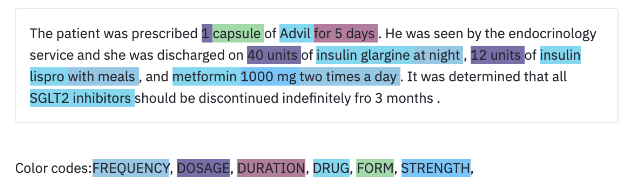

In [ ]:
# NER model trained on i2b2 (sampled from MIMIC) dataset
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

posology_ner_converter = NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

# greedy model
posology_ner_greedy = MedicalNerModel.pretrained("ner_posology_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_greedy")

ner_converter_greedy = NerConverter()\
    .setInputCols(["sentence","token","ner_greedy"])\
    .setOutputCol("ner_chunk_greedy")

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    posology_ner_converter,
    posology_ner_greedy,
    ner_converter_greedy])

empty_data = spark.createDataFrame([[""]]).toDF("text")

posology_model = nlpPipeline.fit(empty_data)


ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
ner_posology_greedy download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [ ]:
posology_ner.getClasses()

['O',
 'B-DOSAGE',
 'B-STRENGTH',
 'I-STRENGTH',
 'B-ROUTE',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'B-DRUG',
 'I-DRUG',
 'B-FORM',
 'I-DOSAGE',
 'B-DURATION',
 'I-DURATION',
 'I-FORM',
 'I-ROUTE']

In [ ]:
posology_result = posology_model.transform(mt_samples_df)

In [ ]:
posology_result.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|          ner_greedy|    ner_chunk_greedy|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|Sample Type / Med...|[{document, 0, 54...|[{document, 0, 54...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 1609, 16...|[{named_entity, 0...|[{chunk, 1609, 16...|
|    1|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 54...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 742, 750...|[{named_entity, 0...|[{chunk, 742, 753...|
|    2|Sample T

In [ ]:
posology_result.printSchema()

root
 |-- index: long (nullable = true)
 |-- text: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- valu

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# This will return a new DF with all the columns + id
posology_result = posology_result.withColumn("id", monotonically_increasing_id())

posology_result.show(3)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|          ner_greedy|    ner_chunk_greedy| id|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|    0|Sample Type / Med...|[{document, 0, 54...|[{document, 0, 54...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 1609, 16...|[{named_entity, 0...|[{chunk, 1609, 16...|  0|
|    1|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 54...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 742, 750...|[{named_entity, 0...|[{chunk, 742, 753...|

In [ ]:
posology_result.select('token.result','ner.result').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, Discharge, Sum...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...|
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, BCCa, Excision...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, 

In [ ]:
posology_result.select('token.result','ner.result').take(2)

[Row(result=['Sample', 'Type', '/', 'Medical', 'Specialty', ':', 'Hematology', '-', 'Oncology', 'Sample', 'Name', ':', 'Discharge', 'Summary', '-', 'Mesothelioma', '-', '1', 'Description', ':', 'Mesothelioma', ',', 'pleural', 'effusion', ',', 'atrial', 'fibrillation', ',', 'anemia', ',', 'ascites', ',', 'esophageal', 'reflux', ',', 'and', 'history', 'of', 'deep', 'venous', 'thrombosis', '.', '(', 'Medical', 'Transcription', 'Sample', 'Report', ')', 'PRINCIPAL', 'DIAGNOSIS', ':', 'Mesothelioma', '.', 'SECONDARY', 'DIAGNOSES', ':', 'Pleural', 'effusion', ',', 'atrial', 'fibrillation', ',', 'anemia', ',', 'ascites', ',', 'esophageal', 'reflux', ',', 'and', 'history', 'of', 'deep', 'venous', 'thrombosis', '.', 'PROCEDURES', '1', '.', 'On', 'August', '24', ',', '2007', ',', 'decortication', 'of', 'the', 'lung', 'with', 'pleural', 'biopsy', 'and', 'transpleural', 'fluoroscopy', '.', '2', '.', 'On', 'August', '20', ',', '2007', ',', 'thoracentesis', '.', '3', '.', 'On', 'August', '31', ',', '

In [ ]:
from pyspark.sql import functions as F

posology_result.select(F.explode(F.arrays_zip('token.result', 'ner.result')).alias("cols")) \
               .select(F.expr("cols['0']").alias("token"),
                       F.expr("cols['1']").alias("ner_label"))\
               .filter("ner_label!='O'")\
               .show(20, truncate=100)


+--------------+-----------+
|         token|  ner_label|
+--------------+-----------+
|      Coumadin|     B-DRUG|
|             1| B-STRENGTH|
|            mg| I-STRENGTH|
|         daily|B-FREQUENCY|
|    Amiodarone|     B-DRUG|
|           100| B-STRENGTH|
|            mg| I-STRENGTH|
|           p.o|    B-ROUTE|
|         daily|B-FREQUENCY|
|      Coumadin|     B-DRUG|
|       Lovenox|     B-DRUG|
|            40| B-STRENGTH|
|            mg| I-STRENGTH|
|subcutaneously|    B-ROUTE|
|  chemotherapy|     B-DRUG|
|     cisplatin|     B-DRUG|
|            75| B-STRENGTH|
| mg/centimeter| I-STRENGTH|
|           109| B-STRENGTH|
|            mg| I-STRENGTH|
+--------------+-----------+
only showing top 20 rows



In [ ]:
posology_result.select('id',F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.begin', 'ner_chunk.end', 'ner_chunk.metadata')).alias("cols")) \
               .select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
                       F.expr("cols['0']").alias("chunk"),
                       F.expr("cols['1']").alias("begin"),
                       F.expr("cols['2']").alias("end"),
                       F.expr("cols['3']['entity']").alias("ner_label"))\
               .filter("ner_label!='O'")\
               .show(truncate=False)

+---+-----------+----------------+-----+----+---------+
|id |sentence_id|chunk           |begin|end |ner_label|
+---+-----------+----------------+-----+----+---------+
|0  |33         |Coumadin        |1609 |1616|DRUG     |
|0  |33         |1 mg            |1618 |1621|STRENGTH |
|0  |33         |daily           |1623 |1627|FREQUENCY|
|0  |34         |Amiodarone      |1696 |1705|DRUG     |
|0  |34         |100 mg          |1707 |1712|STRENGTH |
|0  |34         |p.o             |1714 |1716|ROUTE    |
|0  |34         |daily           |1719 |1723|FREQUENCY|
|0  |58         |Coumadin        |2770 |2777|DRUG     |
|0  |60         |Lovenox         |2880 |2886|DRUG     |
|0  |60         |40 mg           |2888 |2892|STRENGTH |
|0  |60         |subcutaneously  |2894 |2907|ROUTE    |
|0  |72         |chemotherapy    |4436 |4447|DRUG     |
|0  |72         |cisplatin       |4475 |4483|DRUG     |
|0  |72         |75 mg/centimeter|4485 |4500|STRENGTH |
|0  |72         |109 mg          |4519 |4524|STR

In [ ]:
posology_result.select('id',F.explode(F.arrays_zip('ner_chunk_greedy.result', 'ner_chunk_greedy.begin', 'ner_chunk_greedy.end', 'ner_chunk_greedy.metadata')).alias("cols")) \
               .select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
                        F.expr("cols['0']").alias("chunk"),
                        F.expr("cols['1']").alias("begin"),
                        F.expr("cols['2']").alias("end"),
                        F.expr("cols['3']['entity']").alias("ner_label"))\
                .filter("ner_label!='O'")\
                .show(truncate=False)

+---+-----------+--------------------------------------------------------------+-----+----+---------+
|id |sentence_id|chunk                                                         |begin|end |ner_label|
+---+-----------+--------------------------------------------------------------+-----+----+---------+
|0  |33         |Coumadin 1 mg                                                 |1609 |1621|DRUG     |
|0  |33         |daily                                                         |1623 |1627|FREQUENCY|
|0  |34         |Amiodarone 100 mg p.o                                         |1696 |1716|DRUG     |
|0  |34         |daily                                                         |1719 |1723|FREQUENCY|
|0  |58         |Coumadin                                                      |2770 |2777|DRUG     |
|0  |72         |chemotherapy                                                  |4436 |4447|DRUG     |
|0  |72         |cisplatin 75 mg/centimeter                                    |44

In [ ]:
posology_result.select('ner_chunk').take(2)[1][0][0].result

'Xylocaine'

In [ ]:
posology_result.select('ner_chunk').take(2)[1][0][0].metadata

{'chunk': '0', 'confidence': '0.9903', 'entity': 'DRUG', 'sentence': '11'}

In [ ]:
posology_light_model = LightPipeline(posology_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely for 3 months .'

posology_light_result = posology_light_model.annotate(text)

list(zip(posology_light_result['token'], posology_light_result['ner']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DOSAGE'),
 ('capsule', 'B-FORM'),
 ('of', 'O'),
 ('Advil', 'B-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('and', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'B-STRENGTH'),
 ('mg', 'I-STRENGTH'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was

In [ ]:
list(zip(posology_light_result['token'], posology_light_result['ner_greedy']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DRUG'),
 ('capsule', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('Advil', 'I-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DRUG'),
 ('units', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('insulin', 'I-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DRUG'),
 ('units', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('insulin', 'I-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('and', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'I-DRUG'),
 ('mg', 'I-DRUG'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was', 

In [ ]:
posology_light_result = posology_light_model.fullAnnotate(text)

chunks = []
entities = []
begin =[]
end = []

for n in posology_light_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
import pandas as pd

posology_result_df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                                   'begin': begin, 'end': end})

posology_result_df.head(15)

,chunks,entities,begin,end
0,1,DOSAGE,27,27
1,capsule,FORM,29,35
2,Advil,DRUG,40,44
3,for 5 days,DURATION,46,55
4,40 units,DOSAGE,126,133
5,insulin glargine,DRUG,138,153
6,at night,FREQUENCY,155,162
7,12 units,DOSAGE,166,173
8,insulin lispro,DRUG,178,191
9,with meals,FREQUENCY,193,202


In [ ]:
chunks = []
entities = []
begin =[]
end = []

for n in posology_light_result[0]['ner_chunk_greedy']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
import pandas as pd

posology_result_greedy_df = pd.DataFrame({'chunks':chunks, 
                                          'entities':entities,
                                          'begin': begin, 
                                          'end': end})

posology_result_greedy_df.head(15)

,chunks,entities,begin,end
0,1 capsule of Advil,DRUG,27,44
1,for 5 days,DURATION,46,55
2,40 units of insulin glargine,DRUG,126,153
3,at night,FREQUENCY,155,162
4,12 units of insulin lispro,DRUG,166,191
5,with meals,FREQUENCY,193,202
6,metformin 1000 mg,DRUG,210,226
7,two times a day,FREQUENCY,228,242
8,SGLT2 inhibitors,DRUG,273,288
9,for 3 months,DURATION,326,337


### Comparison of `ner_posology` and `ner_posology_greedy` results

In [ ]:
from google.colab import widgets

t = widgets.TabBar(["ner_posology", "ner_posology_greedy", "viz_posology", "viz_posology_greedy"])

with t.output_to(0):
    display(posology_result_df.head(10))

with t.output_to(1):
    display(posology_result_greedy_df.head(10))

with t.output_to(2):
    visualiser.display(posology_light_result[0], label_col='ner_chunk', document_col='document')

with t.output_to(3):
    visualiser.display(posology_light_result[0], label_col='ner_chunk_greedy', document_col='document')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunks,entities,begin,end
0,1,DOSAGE,27,27
1,capsule,FORM,29,35
2,Advil,DRUG,40,44
3,for 5 days,DURATION,46,55
4,40 units,DOSAGE,126,133
5,insulin glargine,DRUG,138,153
6,at night,FREQUENCY,155,162
7,12 units,DOSAGE,166,173
8,insulin lispro,DRUG,178,191
9,with meals,FREQUENCY,193,202


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunks,entities,begin,end
0,1 capsule of Advil,DRUG,27,44
1,for 5 days,DURATION,46,55
2,40 units of insulin glargine,DRUG,126,153
3,at night,FREQUENCY,155,162
4,12 units of insulin lispro,DRUG,166,191
5,with meals,FREQUENCY,193,202
6,metformin 1000 mg,DRUG,210,226
7,two times a day,FREQUENCY,228,242
8,SGLT2 inhibitors,DRUG,273,288
9,for 3 months,DURATION,326,337


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Writing a generic NER function

**Generic NER Function with LightPipeline**

In [ ]:
def get_light_model (embeddings, model_name = 'ner_clinical'):

  documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

  sentenceDetector = SentenceDetector()\
      .setInputCols(["document"])\
      .setOutputCol("sentence")

  tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

  word_embeddings = WordEmbeddingsModel.pretrained(embeddings, "en", "clinical/models")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")

  loaded_ner_model = MedicalNerModel.pretrained(model_name, "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings"]) \
      .setOutputCol("ner")

  ner_converter = NerConverter() \
      .setInputCols(["sentence", "token", "ner"]) \
      .setOutputCol("ner_chunk")

  nlpPipeline = Pipeline(stages=[
      documentAssembler,
      sentenceDetector,
      tokenizer,
      word_embeddings,
      loaded_ner_model,
      ner_converter])

  model = nlpPipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

  return LightPipeline(model)

**Get NER Results with fullAnnotate Method**

In [ ]:
import pandas as pd

def get_light_result (light_model, text, chunk_name="ner_chunk"):

  light_result = light_model.fullAnnotate(text)

  chunks = []
  entities = []
  sentence= []
  begin = []
  end = []

  for n in light_result[0][chunk_name]:
                  
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence']) 
      
    pd_df = pd.DataFrame({'sentence_id':sentence, 
                          'begin': begin, 
                          'end':end, 
                          'chunks':chunks,  
                          'entities':entities})
  return pd_df

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_clinical'

light_model = get_light_model (embeddings, model_name)

text = "I had a headache yesterday and took an Advil."

light_model.annotate(text)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


{'document': ['I had a headache yesterday and took an Advil.'],
 'embeddings': ['I',
  'had',
  'a',
  'headache',
  'yesterday',
  'and',
  'took',
  'an',
  'Advil',
  '.'],
 'ner': ['O',
  'O',
  'B-PROBLEM',
  'I-PROBLEM',
  'O',
  'O',
  'O',
  'B-TREATMENT',
  'I-TREATMENT',
  'O'],
 'ner_chunk': ['a headache', 'an Advil'],
 'sentence': ['I had a headache yesterday and took an Advil.'],
 'token': ['I',
  'had',
  'a',
  'headache',
  'yesterday',
  'and',
  'took',
  'an',
  'Advil',
  '.']}

In [ ]:
get_light_result(light_model, text, chunk_name="ner_chunk")

,sentence_id,begin,end,chunks,entities
0,0,6,15,a headache,PROBLEM
1,0,36,43,an Advil,TREATMENT


In [ ]:
text ='''The patient was prescribed 1 capsule of Parol with meals . 
He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . 
It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'''

embeddings = 'embeddings_clinical'

model_name = 'ner_posology'

light_model = get_light_model (embeddings, model_name)

get_light_result (light_model, text, chunk_name="ner_chunk")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


,sentence_id,begin,end,chunks,entities
0,0,27,27,1,DOSAGE
1,0,29,35,capsule,FORM
2,0,40,44,Parol,DRUG
3,0,46,55,with meals,FREQUENCY
4,1,127,134,40 units,DOSAGE
5,1,139,154,insulin glargine,DRUG
6,1,156,163,at night,FREQUENCY
7,1,167,174,12 units,DOSAGE
8,1,179,192,insulin lispro,DRUG
9,1,194,203,with meals,FREQUENCY


## PHI NER

**Entities**
- AGE
- CONTACT
- DATE
- ID
- LOCATION
- NAME
- PROFESSION

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_deid_subentity_augmented'

# deidentify_dl
# ner_deid_large
# ner_deid_generic_augmented
# ner_deid_subentity_augmented
# ner_deid_subentity_augmented_i2b2

text = """Miriam BRAY is a 41-year-old female from Vietnam and she was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold.
She was instructed to followup with Dr. XYZ in the office to check her INR On August 24, 2007 ."""

light_model = get_light_model (embeddings, model_name)

get_light_result (light_model, text, chunk_name="ner_chunk")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_subentity_augmented download started this may take some time.
Approximate size to download 14.1 MB
[OK!]


,sentence_id,begin,end,chunks,entities
0,0,0,10,Miriam BRAY,PATIENT
1,0,17,27,41-year-old,AGE
2,0,41,47,Vietnam,COUNTRY
3,0,126,131,Monday,DATE
4,0,140,140,X,DOCTOR
5,1,216,218,XYZ,DOCTOR
6,1,254,270,"August 24, 2007 .",DATE


## BioNLP (Cancer Genetics) NER

**Entities**

| | | |
|-|-|-|
|tissue_structure|Amino_acid|Simple_chemical|
|Organism_substance|Developing_anatomical_structure|Cell|
|Cancer|Cellular_component|Gene_or_gene_product|
|Immaterial_anatomical_entity|Organ|Organism|
|Pathological_formation|Organism_subdivision|Anatomical_system|
|Tissue|||

In [ ]:
mt_samples_df.filter("index == '2'").collect()[0]["text"]

'Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nAnemia - Consult\nDescription:\nRefractory anemia that is transfusion dependent. At this time, he has been admitted for anemia with hemoglobin of 7.1 and requiring transfusion.\n(Medical Transcription Sample Report)\nDIAGNOSIS:\nRefractory anemia that is transfusion dependent.\nCHIEF COMPLAINT:\nI needed a blood transfusion.\nHISTORY:\nThe patient is a 78-year-old gentleman with no substantial past medical history except for diabetes. He denies any comorbid complications of the diabetes including kidney disease, heart disease, stroke, vision loss, or neuropathy. At this time, he has been admitted for anemia with hemoglobin of 7.1 and requiring transfusion. He reports that he has no signs or symptom of bleeding and had a blood transfusion approximately two months ago and actually several weeks before that blood transfusion, he had a transfusion for anemia. He has been placed on B12, oral iron, and Procrit. At this t

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_bionlp'

text =  mt_samples_df.filter("index == '2'").collect()[0]["text"]

light_model = get_light_model (embeddings, model_name)

get_light_result (light_model, text, chunk_name="ner_chunk").head(20)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_bionlp download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


,sentence_id,begin,end,chunks,entities
0,1,198,207,hemoglobin,Gene_or_gene_product
1,3,369,373,blood,Organism_substance
2,4,401,407,patient,Organism
3,4,426,434,gentleman,Organism
4,5,498,499,He,Organism
5,5,561,566,kidney,Organ
6,5,577,581,heart,Organ
7,6,679,688,hemoglobin,Gene_or_gene_product
8,7,789,793,blood,Organism_substance
9,7,875,879,blood,Organism_substance


## NER Chunker
We can extract phrases that fits into a known pattern using the NER tags. NerChunker would be quite handy to extract entity groups with neighboring tokens when there is no pretrained NER model to address certain issues. Lets say we want to extract drug and frequency together as a single chunk even if there are some unwanted tokens between them. 

In [ ]:
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_chunker = NerChunker()\
    .setInputCols(["sentence","ner"])\
    .setOutputCol("ner_chunk")\
    .setRegexParsers(["<DRUG>.*<FREQUENCY>"])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_chunker])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ner_chunker_model = nlpPipeline.fit(empty_data)

ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [ ]:
posology_ner.getClasses()

['O',
 'B-DOSAGE',
 'B-STRENGTH',
 'I-STRENGTH',
 'B-ROUTE',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'B-DRUG',
 'I-DRUG',
 'B-FORM',
 'I-DOSAGE',
 'B-DURATION',
 'I-DURATION',
 'I-FORM',
 'I-ROUTE']

In [ ]:
light_model = LightPipeline(ner_chunker_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

list(zip(light_result['token'], light_result['ner']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DOSAGE'),
 ('capsule', 'B-FORM'),
 ('of', 'O'),
 ('Advil', 'B-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'B-STRENGTH'),
 ('mg', 'I-STRENGTH'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was', 'O'),
 ('det

In [ ]:
light_result["ner_chunk"]

['insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day']

## Chunk Filterer
ChunkFilterer will allow you to filter out named entities by some conditions or predefined look-up lists, so that you can feed these entities to other annotators like Assertion Status or Entity Resolvers. It can be used with two criteria: isin and regex.

In [ ]:
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")
      
chunk_filterer = ChunkFilterer()\
    .setInputCols("sentence","ner_chunk")\
    .setOutputCol("chunk_filtered")\
    .setCriteria("isin")\
    .setWhiteList(['Advil','metformin', 'insulin lispro'])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_converter,
    chunk_filterer])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chunk_filter_model = nlpPipeline.fit(empty_data)

ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [ ]:
light_model = LightPipeline(chunk_filter_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

light_result.keys()

dict_keys(['document', 'ner_chunk', 'chunk_filtered', 'token', 'ner', 'embeddings', 'sentence'])

In [ ]:
light_result['ner_chunk'] 

['1',
 'capsule',
 'Advil',
 'for 5 days',
 '40 units',
 'insulin glargine',
 'at night',
 '12 units',
 'insulin lispro',
 'with meals',
 'metformin',
 '1000 mg',
 'two times a day',
 'SGLT2 inhibitors']

In [ ]:
light_result['chunk_filtered']

['Advil', 'insulin lispro', 'metformin']

In [ ]:
ner_model = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models")\
    .setInputCols("sentence","token","embeddings")\
    .setOutputCol("ner")

ner_converter = NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")
    
chunk_filterer = ChunkFilterer()\
    .setInputCols("sentence","ner_chunk")\
    .setOutputCol("chunk_filtered")\
    .setCriteria("isin")\
    .setWhiteList(['severe fever','sore throat'])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ner_model,
    ner_converter,
    chunk_filterer])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chunk_filter_model = nlpPipeline.fit(empty_data)

ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [ ]:
text = 'Patient with severe fever, severe cough, sore throat, stomach pain, and a headache.'

filter_df = spark.createDataFrame([[text]]).toDF("text")

chunk_filter_result = chunk_filter_model.transform(filter_df)

In [ ]:
chunk_filter_result.select('ner_chunk.result','chunk_filtered.result').show(truncate=False)

+-------------------------------------------------------------------+---------------------------+
|result                                                             |result                     |
+-------------------------------------------------------------------+---------------------------+
|[severe fever, severe cough, sore throat, stomach pain, a headache]|[severe fever, sore throat]|
+-------------------------------------------------------------------+---------------------------+



## Changing entity labels with `NerConverterInternal()`

In [ ]:
replace_dict = """Drug_BrandName,Drug
Frequency,Drug_Frequency
Dosage,Drug_Dosage
Strength,Drug_Strength
"""
with open('replace_dict.csv', 'w') as f:
    f.write(replace_dict)

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") 

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")

jsl_ner_converter_internal = NerConverterInternal()\
    .setInputCols(["sentence","token","jsl_ner"])\
    .setOutputCol("replaced_ner_chunk")\
    .setReplaceDictResource("replace_dict.csv","text", {"delimiter":","})
      
nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter,
    jsl_ner_converter_internal
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ner_converter_model = nlpPipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
Approximate size to download 14.5 MB
[OK!]


In [ ]:
text ='The patient was prescribed 1 capsule of Parol with meals . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_model = LightPipeline(ner_converter_model)

jsl_ner_chunk_df = get_light_result (light_model, text, chunk_name='jsl_ner_chunk')
replaced_ner_chunk_df = get_light_result (light_model, text, chunk_name='replaced_ner_chunk')
pd.concat([jsl_ner_chunk_df, replaced_ner_chunk_df.iloc[:,-1:].rename(columns= {'entities':'replaced'})], axis=1)

,sentence_id,begin,end,chunks,entities,replaced
0,0,27,35,1 capsule,Dosage,Drug_Dosage
1,0,40,44,Parol,Drug_BrandName,Drug
2,1,59,60,He,Gender,Gender
3,1,78,98,endocrinology service,Clinical_Dept,Clinical_Dept
4,1,104,106,she,Gender,Gender
5,1,112,121,discharged,Admission_Discharge,Admission_Discharge
6,1,126,133,40 units,Dosage,Drug_Dosage
7,1,138,153,insulin glargine,Drug_Ingredient,Drug_Ingredient
8,1,155,162,at night,Frequency,Drug_Frequency
9,1,166,173,12 units,Dosage,Drug_Dosage


## Downloading Pretrained Models

- When we use `.pretrained` method, model is downloaded to  a folder named `cache_pretrained` automatically and it is loaded from thit folder if you run it again.

- In order to download the models manually to any folder, you can follow the steps below. In this case you should use `.load()` method.

  - Install AWS CLI to your local computer following the steps [here](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-linux.html) for Linux and [here](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-mac.html) for MacOS.

  - Then configure your AWS credentials.

  - Go to models hub and look for the model you need.

  - Select the model you found and you will see the model card that shows all the details about that model.

  - Hover the Download button on that page and you will see the download link from the S3 bucket. 

  - Just use AWS CLI like follows:

```
!aws s3 cp --region us-east-2 s3://auxdata.johnsnowlabs.com/clinical/models/ner_jsl_en_3.1.0_2.4_1624566960534.zip .
```

## Training a Clinical NER (NCBI Disease Dataset)

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltrain.txt
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltest.txt

In [ ]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'NER_NCBIconlltrain.txt')

conll_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Identification of...|[{document, 0, 89...|[{document, 0, 89...|[{token, 0, 13, I...|[{pos, 0, 13, NN,...|[{named_entity, 0...|
|The adenomatous p...|[{document, 0, 21...|[{document, 0, 21...|[{token, 0, 2, Th...|[{pos, 0, 2, NN, ...|[{named_entity, 0...|
|Complex formation...|[{document, 0, 63...|[{document, 0, 63...|[{token, 0, 6, Co...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
conll_data.count()

3266

In [ ]:
from pyspark.sql import functions as F

conll_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |75093|
|I-Disease   |3547 |
|B-Disease   |3093 |
+------------+-----+



In [ ]:
conll_data.select("label.result").distinct().count()

1537

As you can see, there are too many **`O`** labels in the dataset and it's a skewed one. To make it more balanced, we will drop the sentences have only **`O`** labels.

**Note:** `c>1` means we drop all the sentences that have no valuable labels other than **`O`**.

In [ ]:
import pyspark.sql.functions as F

#conll_data.select(F.countDistinct("label.result")).show()
#conll_data.groupBy("label.result").count().show(truncate=False)

conll_data = conll_data.withColumn('unique', F.array_distinct("label.result"))\
                       .withColumn('c', F.size('unique'))\
                       .filter(F.col('c')>1)

conll_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |39427|
|I-Disease   |3547 |
|B-Disease   |3093 |
+------------+-----+



In [ ]:
# Clinical word embeddings trained on PubMED dataset
clinical_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [ ]:
test_data = CoNLL().readDataset(spark, 'NER_NCBIconlltest.txt')

test_data = clinical_embeddings.transform(test_data)

test_data.write.parquet('NER_NCBIconlltest.parquet')

### NERDL Graph
TensorFlow graph file (`.pb` extension) should be produced for NER training.

In [ ]:
!pip install -q tensorflow==2.7.0
!pip install -q tensorflow-addons

In [ ]:
from sparknlp_jsl.training import tf_graph
tf_graph.print_model_params("ner_dl")

tf_graph.build("ner_dl", 
               build_params={"embeddings_dim": 200, 
                             "nchars": 85, 
                             "ntags": 3, 
                             "is_medical": 1}, 
               model_location="./medical_ner_graphs", 
               model_filename="auto")

In [ ]:
# for open source users
'''
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/create_graph.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/dataset_encoder.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model_saver.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/sentence_grouper.py

!pip -q install tensorflow==1.15.0

import create_graph

ntags = 3 # number of labels
embeddings_dim = 200
nchars =83

create_graph.create_graph(ntags, embeddings_dim, nchars)
'''

In [ ]:
nerTagger = MedicalNerApproach()\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(30)\
    .setBatchSize(64)\
    .setRandomSeed(0)\
    .setVerbose(1)\
    .setValidationSplit(0.2)\
    .setEvaluationLogExtended(True) \
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setOutputLogsPath('ner_logs')\
    .setGraphFolder('medical_ner_graphs')\
    .setTestDataset("NER_NCBIconlltest.parquet")\
    .setUseBestModel(True)\
    .setEarlyStoppingCriterion(0.04)\
    .setEarlyStoppingPatience(3)\
   # .setEnableMemoryOptimizer(True) #>> if you have a limited memory and a large conll file, you can set this True to train batch by batch       

ner_pipeline = Pipeline(stages=[
          clinical_embeddings,
          nerTagger
 ])

You can visit [1.4.Resume_MedicalNer_Model_Training.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.4.Resume_MedicalNer_Model_Training.ipynb) notebook for fine-tuning pretrained NER models and more details of `MedicalNerApproach()` parameters.

In [ ]:
%%time
ner_model = ner_pipeline.fit(conll_data)

# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook in public folder to create a graph
# licensed users can also use 17.Graph_builder_for_DL_models.ipynb to create tf graphs easily.

CPU times: user 3.73 s, sys: 373 ms, total: 4.11 s
Wall time: 10min 19s


`getTrainingClassDistribution()` parameter returns the distribution of labels used when training the NER model.

In [ ]:
ner_model.stages[1].getTrainingClassDistribution()

{'O': 31268, 'B-Disease': 2435, 'I-Disease': 2767}

Let's check the results saved in the log file.

In [ ]:
import os 
log_file= os.listdir("ner_logs")[0]

with open (f"./ner_logs/{log_file}") as f:
  print(f.read())

Name of the selected graph: /content/medical_ner_graphs/blstm_3_200_128_85.pb
Training started - total epochs: 30 - lr: 0.001 - batch size: 64 - labels: 3 - chars: 82 - training examples: 1349


Epoch 1/30 started, lr: 0.001, dataset size: 1349


Epoch 1/30 - 45.45s - loss: 268.51636 - avg training loss: 12.205289 - batches: 22
Quality on validation dataset (20.0%), validation examples = 269
time to finish evaluation: 8.00s
Total validation loss: 49.3032	Avg validation loss: 8.2172
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 273	 174	 507	 0.6107383	 0.35	 0.44498777
B-Disease	 123	 98	 535	 0.5565611	 0.18693009	 0.2798635
tp: 396 fp: 272 fn: 1042 labels: 2
Macro-average	 prec: 0.5836497, rec: 0.26846504, f1: 0.3677663
Micro-average	 prec: 0.5928144, rec: 0.2753825, f1: 0.3760684
Quality on test dataset: 
time to finish evaluation: 7.20s
Total test loss: 53.1750	Avg test loss: 4.8341
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 255	 179	 534	 0.5875576	 0.3231939	 0.41700733
B-Disease	

As you see above, our **earlyStopping** feature worked, trainining was terminated before 30th epoch.

### Evaluate your model

In [ ]:
pred_df = ner_model.stages[1].transform(test_data)

In [ ]:
pred_df.columns

['text', 'document', 'sentence', 'token', 'pos', 'label', 'embeddings', 'ner']

In [ ]:
from sparknlp_jsl.eval import NerDLMetrics
import pyspark.sql.functions as F

evaler = NerDLMetrics(mode="full_chunk", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+-----+-----+-----+-----+---------+------+------+
| entity|   tp|   fp|   fn|total|precision|recall|    f1|
+-------+-----+-----+-----+-----+---------+------+------+
|Disease|598.0|183.0|106.0|704.0|   0.7657|0.8494|0.8054|
+-------+-----+-----+-----+-----+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.8053872053872054|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.8053872053872054|
+------------------+

None


In [ ]:
evaler = NerDLMetrics(mode="partial_chunk_per_token", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+------+-----+-----+------+---------+------+------+
| entity|    tp|   fp|   fn| total|precision|recall|    f1|
+-------+------+-----+-----+------+---------+------+------+
|Disease|1342.0|198.0|155.0|1497.0|   0.8714|0.8965|0.8838|
+-------+------+-----+-----+------+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.8837668752057952|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.8837668752057952|
+------------------+

None


In [ ]:
ner_model.stages[1].write().overwrite().save('models/custom_NER_30epoch')

In [ ]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

loaded_ner_model = MedicalNerModel.load("models/custom_NER_30epoch")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = NerConverter()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        clinical_embeddings,
        loaded_ner_model,
        converter])

empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [ ]:
text = "She has a metastatic breast cancer"

result = light_model.fullAnnotate(text)[0]

[(i.result, i.metadata['entity']) for i in result['ner_span']]

[('metastatic breast cancer', 'Disease')]

## BertForTokenClassification NER models

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

tokenClassifier = MedicalBertForTokenClassifier.pretrained("bert_token_classifier_ner_clinical", "en", "clinical/models")\
    .setInputCols("token", "sentence")\
    .setOutputCol("ner")\
    .setCaseSensitive(True)

ner_converter = NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

pipeline =  Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        tokenClassifier,
        ner_converter
        ])

model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

text = """A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . 
Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . 
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . 
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . 
Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . 
Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . 
The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . 
However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . 
The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . 
The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . 
Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . 
The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . 
It was determined that all SGLT2 inhibitors should be discontinued indefinitely . She had close follow-up with endocrinology post discharge ."""

res = model.transform(spark.createDataFrame([[text]]).toDF("text"))

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
bert_token_classifier_ner_clinical download started this may take some time.
Approximate size to download 385.6 MB
[OK!]


In [ ]:
from pyspark.sql import functions as F

res.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.begin', 'ner_chunk.end', 'ner_chunk.metadata')).alias("cols")) \
    .select(F.expr("cols['3']['sentence']").alias("sentence_id"),
            F.expr("cols['0']").alias("chunk"),
            F.expr("cols['2']").alias("end"),
            F.expr("cols['3']['entity']").alias("ner_label"))\
    .filter("ner_label!='O'")\
    .show(truncate=False)

+-----------+-----------------------------+---+---------+
|sentence_id|chunk                        |end|ner_label|
+-----------+-----------------------------+---+---------+
|0          |gestational diabetes mellitus|67 |PROBLEM  |
|0          |type two diabetes mellitus   |153|PROBLEM  |
|0          |T2DM                         |160|PROBLEM  |
|0          |HTG-induced pancreatitis     |209|PROBLEM  |
|0          |an acute hepatitis           |280|PROBLEM  |
|0          |obesity                      |294|PROBLEM  |
|0          |a body mass index            |317|TEST     |
|0          |BMI                          |323|TEST     |
|0          |polyuria                     |387|PROBLEM  |
|0          |polydipsia                   |400|PROBLEM  |
|0          |poor appetite                |416|PROBLEM  |
|0          |vomiting                     |431|PROBLEM  |
|1          |amoxicillin                  |522|TREATMENT|
|1          |a respiratory tract infection|556|PROBLEM  |
|2          |m

In [ ]:
light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)

from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document', save_path="display_bert_result.html")

**Training Clinical BertForTokenClassification Model**

For training own BertForTokenClassification NER model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.5.BertForTokenClassification_NER_SparkNLP_with_Transformers.ipynb)

## Pretrained NER Profiling Pipelines

We can use pretrained NER profiling pipelines for exploring all the available pretrained NER models at once. In Spark NLP we have two different NER profiling pipelines;

- `ner_profiling_clinical` : Returns results for clinical NER models trained with `embeddings_clinical`.
- `ner_profiling_biobert` : Returns results for clinical NER models trained with `biobert_pubmed_base_cased`.

For more examples, please check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.2.Pretrained_NER_Profiling_Pipelines.ipynb).





**`ner_profiling_clinical` Model List**

|   index | model                             |   index | model                        |   index | model                          |   index | model                           |
|--------:|:----------------------------------|--------:|:-----------------------------|--------:|:-------------------------------|--------:|:--------------------------------|
|       1 | ner_ade_clinical                  |      13 | nerdl_tumour_demo            |      25 | ner_drugs                      |      37 | ner_radiology_wip_clinical      |
|       2 | ner_posology_greedy               |      14 | ner_deid_subentity_augmented |      26 | ner_deid_sd                    |      38 | ner_clinical                    |
|       3 | ner_risk_factors                  |      15 | ner_jsl_enriched             |      27 | ner_posology_large             |      39 | ner_chemicals                   |
|       4 | jsl_ner_wip_clinical              |      16 | ner_genetic_variants         |      28 | ner_deid_large                 |      40 | ner_deid_synthetic              |
|       5 | ner_human_phenotype_gene_clinical |      17 | ner_bionlp                   |      29 | ner_posology                   |      41 | ner_events_clinical             |
|       6 | jsl_ner_wip_greedy_clinical       |      18 | ner_measurements_clinical    |      30 | ner_deidentify_dl              |      42 | ner_posology_small              |
|       7 | ner_cellular                      |      19 | ner_diseases_large           |      31 | ner_deid_enriched              |      43 | ner_anatomy_coarse              |
|       8 | ner_cancer_genetics               |      20 | ner_radiology                |      32 | ner_bacterial_species          |      44 | ner_human_phenotype_go_clinical |
|       9 | jsl_ner_wip_modifier_clinical     |      21 | ner_deid_augmented           |      33 | ner_drugs_large                |      45 | ner_jsl_slim                    |
|      10 | ner_drugs_greedy                  |      22 | ner_anatomy                  |      34 | ner_clinical_large             |      46 | ner_jsl                         |
|      11 | ner_deid_sd_large                 |      23 | ner_chemprot_clinical        |      35 | jsl_rd_ner_wip_greedy_clinical |      47 | ner_jsl_greedy                  |
|      12 | ner_diseases                      |      24 | ner_posology_experimental    |      36 | ner_medmentions_coarse         |      48 | ner_events_admission_clinical   |

**`ner_profiling_BERT` Model List**



|   index | model                  |   index | model                            |   index | model                         |
|--------:|:-----------------------|--------:|:---------------------------------|--------:|:------------------------------|
|       1 | ner_cellular_biobert   |       8 | ner_jsl_enriched_biobert         |      15 | ner_posology_large_biobert    |
|       2 | ner_diseases_biobert   |       9 | ner_human_phenotype_go_biobert   |      16 | jsl_rd_ner_wip_greedy_biobert |
|       3 | ner_events_biobert     |      10 | ner_deid_biobert                 |      17 | ner_posology_biobert          |
|       4 | ner_bionlp_biobert     |      11 | ner_deid_enriched_biobert        |      18 | jsl_ner_wip_greedy_biobert    |
|       5 | ner_jsl_greedy_biobert |      12 | ner_clinical_biobert             |      19 | ner_chemprot_biobert          |
|       6 | ner_jsl_biobert        |      13 | ner_anatomy_coarse_biobert       |      20 | ner_ade_biobert               |
|       7 | ner_anatomy_biobert    |      14 | ner_human_phenotype_gene_biobert |      21 | ner_risk_factors_biobert      |

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

clinical_profiling_pipeline = PretrainedPipeline("ner_profiling_clinical", "en", "clinical/models")

ner_profiling_clinical download started this may take some time.
Approx size to download 2.3 GB
[OK!]


In [ ]:
text = '''A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting .'''

In [ ]:
clinical_result = clinical_profiling_pipeline.fullAnnotate(text)[0]
clinical_result.keys()

dict_keys(['ner_ade_clinical_chunks', 'ner_deid_augmented', 'ner_posology_greedy_chunks', 'ner_radiology_wip_clinical', 'ner_deidentify_dl', 'ner_jsl_slim', 'ner_risk_factors_chunks', 'jsl_ner_wip_clinical_chunks', 'ner_deid_synthetic', 'ner_drugs_greedy', 'ner_human_phenotype_gene_clinical_chunks', 'ner_events_admission_clinical', 'jsl_ner_wip_greedy_clinical_chunks', 'ner_posology_greedy', 'ner_cellular_chunks', 'ner_cancer_genetics_chunks', 'ner_jsl_greedy', 'jsl_ner_wip_modifier_clinical_chunks', 'ner_drugs_greedy_chunks', 'ner_deid_sd_large_chunks', 'ner_diseases_chunks', 'ner_diseases_large', 'ner_chemprot_clinical', 'ner_posology_large', 'nerdl_tumour_demo_chunks', 'ner_deid_subentity_augmented_chunks', 'ner_jsl_enriched_chunks', 'ner_genetic_variants_chunks', 'ner_chexpert', 'ner_bionlp_chunks', 'ner_measurements_clinical_chunks', 'ner_diseases_large_chunks', 'ner_drugs_large', 'ner_clinical_large', 'ner_chemicals', 'ner_radiology_chunks', 'ner_bacterial_species', 'ner_deid_aug

In [ ]:
import pandas as pd

def get_token_results(light_result):

  tokens = [j.result for j in light_result["token"]]
  sentences = [j.metadata["sentence"] for j in light_result["token"]]
  begins = [j.begin for j in light_result["token"]]
  ends = [j.end for j in light_result["token"]]
  model_list = [ a for a in light_result.keys() if (a not in ["sentence", "token"] and "_chunks" not in a)]

  df = pd.DataFrame({'sentence':sentences, 'begin': begins, 'end': ends, 'token':tokens})

  for model_name in model_list:
    
    temp_df = pd.DataFrame(light_result[model_name])
    temp_df["jsl_label"] = temp_df.iloc[:,0].apply(lambda x : x.result)
    temp_df = temp_df[["jsl_label"]]

    # temp_df = get_ner_result(model_name)
    temp_df.columns = [model_name]
    df = pd.concat([df, temp_df], axis=1)
    
  return df

In [ ]:
get_token_results(clinical_result)

,sentence,begin,end,token,ner_deid_augmented,ner_radiology_wip_clinical,ner_deidentify_dl,ner_jsl_slim,ner_deid_synthetic,ner_drugs_greedy,...,ner_deid_subentity_augmented,ner_measurements_clinical,ner_jsl_enriched,ner_posology_experimental,jsl_ner_wip_clinical,ner_jsl,ner_events_clinical,ner_genetic_variants,ner_radiology,ner_posology
0,0,0,0,A,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
1,0,2,12,28-year-old,O,O,O,B-Age,O,O,...,B-AGE,O,B-Age,O,B-Age,B-Age,O,O,O,O
2,0,14,19,female,O,O,O,B-Demographics,O,O,...,O,O,B-Gender,O,B-Gender,B-Gender,O,O,O,O
3,0,21,24,with,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
4,0,26,26,a,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,409,416,appetite,O,I-Symptom,O,I-Symptom,O,O,...,O,O,I-Symptom,O,I-Symptom,I-Symptom,I-PROBLEM,O,I-Symptom,O
69,0,418,418,",",O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
70,0,420,422,and,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
71,0,424,431,vomiting,O,B-Symptom,O,B-Symptom,O,O,...,O,O,B-Symptom,O,B-Symptom,B-Symptom,B-PROBLEM,O,B-Symptom,O


## NER Model Finder Pretrained Pipeline
`ner_model_finder`  pretrained pipeline trained with bert embeddings that can be used to find the most appropriate NER model given the entity name.

In [ ]:
from sparknlp.pretrained import PretrainedPipeline
finder_pipeline = PretrainedPipeline("ner_model_finder", "en", "clinical/models")

ner_model_finder download started this may take some time.
Approx size to download 148.6 MB
[OK!]


In [ ]:
result = finder_pipeline.fullAnnotate("oncology")[0]
result.keys()

dict_keys(['model_names'])

From the metadata in the `model_names` column, we'll get to the top models to the given 'oncology' entity and oncology related categories.

In [ ]:
df= pd.DataFrame(zip(result["model_names"][0].metadata["all_k_resolutions"].split(":::"), 
                     result["model_names"][0].metadata["all_k_results"].split(":::")), 
                 columns=["category", "top_models"])

In [ ]:
df.head()

,category,top_models
0,oncology therapy,"['ner_jsl_enriched', 'jsl_rd_ner_wip_greedy_cl..."
1,clinical department,"['jsl_rd_ner_wip_greedy_clinical', 'ner_jsl_en..."
2,cancer genetics,['ner_cancer_genetics']
3,anatomy,"['ner_bionlp', 'ner_anatomy', 'ner_chexpert', ..."
4,molecular biology research technique,['ner_medmentions_coarse']
